In [ ]:
from datetime import datetime
from joblib import Parallel, delayed
import lightgbm as lgb
from lightgbm.callback import early_stopping, log_evaluation
import numpy as np
import pandas as pd
import random
from scipy.signal import resample
from sdtw import SoftDTW
from sdtw.distance import SquaredEuclidean

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [18, 6]

In [ ]:
from truth import IeeeGroundTruth
from wavelet import apply_wavelet
from peaks import get_peaks_v2
from signal_pross import (
    normalize_signal,
    detrend_w_poly,
    normalize_amplitude_to_1,
    n_moving_avg,
    min_max_scale,
    bandpass,
    get_hr
)

In [ ]:
truths = []
for subject in range(1, 8):

    truth = IeeeGroundTruth(subject, 1, directory = 'channel_data3')
    truth.align_rgb_bvp()
    truth.fill_nans()
    truth.process_rgb()
    truth.process_bvp()

    truths.append(truth)

In [ ]:
class LossFactory:

    def __init__(self, total_samples, split_size, loss_type = 'mse', gamma = 1.0, mse_weight = None, dtw_weight = None):
        
        if loss_type not in ['mse', 'dtw', 'combined']:
            raise ValueError(f'Loss type [{loss_type}] not supported')
        
        self.total_samples = total_samples
        self.split_size = split_size
        self.gamma = gamma
        self.mse_weight = mse_weight
        self.dtw_weight = dtw_weight

        if loss_type == 'mse':
            self.loss_function = self.mse_loss
        elif loss_type == 'dtw':
            self.loss_function = self.soft_dtw_loss
        elif loss_type == 'combined':
            self.loss_function = self.combined_loss
        
    def __call__(self, y_pred, data):
        return self.loss_function(y_pred, data)

    def mse_loss(self, y_pred, data):
        
        y_true = data.get_label()
        num_batches = int(self.total_samples / self.split_size)
        errs = np.zeros_like(y_true)

        for i in range(num_batches):

            y_true_curr = y_true[i * self.split_size: (i + 1) * self.split_size]
            y_pred_curr = y_pred[i * self.split_size: (i + 1) * self.split_size]
            
            err = y_true_curr - y_pred_curr
            errs[i * self.split_size: (i + 1) * self.split_size] = err

        grad = -2 * errs
        hess = 2 * np.ones_like(y_true)
        return grad, hess

    def soft_dtw_loss(self, y_pred, data):

        y_true = data.get_label()
        num_batches = int(self.total_samples / self.split_size)
        grads = np.zeros_like(y_true)
        hesses = np.zeros_like(y_true)

        for i in range(num_batches):

            y_true_curr = y_true[i * self.split_size: (i + 1) * self.split_size]
            y_pred_curr = y_pred[i * self.split_size: (i + 1) * self.split_size]
            
            grad_curr, hess_curr = self.soft_dtw_loss_helper(y_true_curr, y_pred_curr)
            grad_curr = grad_curr.flatten()
            hess_curr = hess_curr.flatten()

            grads[i * self.split_size: (i + 1) * self.split_size] = grad_curr
            hesses[i * self.split_size: (i + 1) * self.split_size] = hess_curr

        return grads, hesses
    
    def soft_dtw_loss_helper(self, y_true, y_pred):
        x = y_true.reshape(-1, 1)
        y = y_pred.reshape(-1, 1)
        D = SquaredEuclidean(x, y)
        sdtw = SoftDTW(D, gamma = self.gamma)
        sdtw.compute()
        E = sdtw.grad()
        G = D.jacobian_product(E)
        return G, np.ones(len(G))
    
    def combined_loss(self, y_pred, data):

        if self.mse_weight is None or self.dtw_weight is None:
            raise ValueError('mse_weight and dtw_weight must be set before calling combined_loss')

        mse_grads, mse_hesses = self.mse_loss(y_pred, data)
        dtw_grads, dtw_hesses = self.soft_dtw_loss(y_pred, data)

        combined_grad = self.mse_weight * mse_grads + self.dtw_weight * dtw_grads
        combined_hess = self.mse_weight * mse_hesses + self.dtw_weight * dtw_hesses

        return combined_grad, combined_hess

In [49]:
class LonePineGBM:
    
    def __init__(self, truths, label_col = 'bvp', subject_col = 'subject',
                # model customization
                model_type = 'gbdt', random_state = None, loss_type = 'mse', excluded_subject = None,
                # hyperparameters
                n_estimators = 100, split_size = 1280, learning_rate = 0.1, test_size = 0.3, early_stopping_rounds = 50,
                mse_weight = None, dtw_weight = None, data_beg = 1000, data_end = 10000):
        
        if model_type not in ['gbdt', 'rf']:
            raise ValueError(f'Model type [{model_type}] not supported')
        
        self.label_col = label_col
        self.subject_col = subject_col

        self.model_type = model_type
        self.random_state = random_state
        self.excluded_subject = excluded_subject

        self.n_estimators = n_estimators
        self.split_size = split_size
        self.learning_rate = learning_rate
        self.test_size = test_size
        self.early_stopping_rounds = early_stopping_rounds

        self.data_beg = data_beg
        self.data_end = data_end

        self.gbm = None
        self.training_loss = None
        self.test_loss = None

        self.given_data = self.prepare_dataset_from_subjects(truths, data_beg = data_beg, data_end = data_end)
        self.features = list(self.given_data.drop(columns = [self.label_col, self.subject_col]).columns)
        if self.excluded_subject is not None:
            self.given_data = self.given_data[self.given_data[self.subject_col] != self.excluded_subject]

        if self.random_state is not None:
            random.seed(self.random_state)
        splits = self.split_data()
        self.train_split_indices = random.sample(range(len(splits)), int(len(splits) * (1 - self.test_size)))
        self.train_splits = [splits[i] for i in self.train_split_indices]
        self.test_splits = [splits[i] for i in range(len(splits)) if i not in self.train_split_indices]
        
        train_indices = [idx for split in self.train_splits for idx in split]
        self.train_data = self.given_data.iloc[train_indices].drop(columns = [self.subject_col])
        self.train_X = self.train_data.drop(columns = [self.label_col]).to_numpy()
        self.train_y = self.train_data[self.label_col].to_numpy()

        test_indices = [idx for split in self.test_splits for idx in split]
        self.test_data = self.given_data.iloc[test_indices].drop(columns = [self.subject_col])
        self.test_X = self.test_data.drop(columns = [self.label_col]).to_numpy()
        self.test_y = self.test_data[self.label_col].to_numpy()

        self.train_data = lgb.Dataset(self.train_X, self.train_y)
        self.test_data = lgb.Dataset(self.test_X, self.test_y)


        self.loss = LossFactory(len(self.train_X), self.split_size, loss_type = loss_type, mse_weight = mse_weight, dtw_weight = dtw_weight)
    
    def split_data(self, to_exclude = None):
        
        data_in_use = self.given_data if to_exclude is None else self.given_data[~self.given_data[self.subject_col].isin(to_exclude)]

        subject_indices = data_in_use.groupby(self.subject_col).indices
        splits = []
        for _, indices in subject_indices.items():
            
            n_splits = len(indices) // self.split_size
            if n_splits > 0:

                subject_splits = []
                for i in range(n_splits):
                    split_start = i * self.split_size
                    split_end = (i + 1) * self.split_size
                    subject_split = indices[split_start: split_end]
                    subject_splits.append(subject_split)
                
                splits.extend(subject_splits)
        
        return splits

    def fit(self):
        t1 = datetime.today()
        
        params = {
            'metric': 'None',
            'verbosity': -1,
            'learning_rate': self.learning_rate,
            'objective': 'regression',
            'boosting': self.model_type,
        }

        training_loss_key = 'hr_err'
        feval = self.hr_error_eval_metric
        
        training_meta = {}
        self.gbm = lgb.train(
            params,
            self.train_data,
            valid_sets = [self.train_data, self.test_data],
            valid_names=['train', 'test'],
            fobj = self.loss,
            num_boost_round = self.n_estimators,
            feval=feval,
            callbacks=[
                early_stopping(stopping_rounds = self.early_stopping_rounds),
                log_evaluation(period=5)
            ],
            evals_result = training_meta
        )

        self.training_loss = training_meta['train'][training_loss_key]
        self.test_loss = training_meta['test'][training_loss_key]
        print(f'Finished training in {datetime.today() - t1}')

    def predict(self, X):
        return self.gbm.predict(X)

    def eval(self):
        
        nsplits = int(len(self.test_X) / self.split_size)
        errs = []
        mses = np.ones_like(self.test_y)
        
        for i in range(nsplits):

            curr_pred = self.predict(self.test_X[i * self.split_size: (i + 1) * self.split_size, :])
            curr_true = self.test_y[i * self.split_size: (i + 1) * self.split_size]
            curr_true, curr_pred = self.process_signal(curr_true, curr_pred, smoothing_window = 5, use_bandpass = True)
            
            mses[i * self.split_size: (i + 1) * self.split_size] = curr_true - curr_pred
            hr_err = self.get_hr_error(curr_true, curr_pred, square = False)
            errs.append(hr_err)
        
        return np.mean(np.square(mses)), np.mean(errs), np.mean(np.square(errs))

    def plot_loss(self):
        if self.training_loss is not None and self.test_loss is not None:
            training_loss_normed = min_max_scale(self.training_loss)
            test_loss_normed = min_max_scale(self.test_loss)
            plt.plot(training_loss_normed, label = 'training loss')
            plt.plot(test_loss_normed, label = 'test loss')
            plt.legend()
        
    def get_model_stats(self):

        model_info = self.gbm.dump_model()
        tree_depths = []

        for tree_info in model_info['tree_info']:
            tree_structure = tree_info['tree_structure']
            
            # Recursive function to compute the depth of a tree
            def calculate_depth(node, current_depth=0):
                if 'leaf_value' in node:
                    return current_depth
                else:
                    left_depth = calculate_depth(node['left_child'], current_depth + 1)
                    right_depth = calculate_depth(node['right_child'], current_depth + 1)
                    return max(left_depth, right_depth)

            tree_depth = calculate_depth(tree_structure)
            tree_depths.append(tree_depth)
        

        print(f'Best test loss: {min(self.test_loss)}\n')
        print('Tree depth stats:')
        print('Min tree depth:', min(tree_depths))
        print('Max tree depth:', max(tree_depths))
        print('Avg tree depth:', np.mean(tree_depths))
        print('\nFeature importances:')
        display(self.get_feature_importances())
    
    def get_feature_importances(self):
        importances = self.gbm.feature_importance(importance_type='gain')
        feature_importances = pd.DataFrame({'feature': self.features, 'importance': importances})
        feature_importances = feature_importances.sort_values('importance', ascending=False)
        return feature_importances
    
    def hr_error_eval_metric(self, y_pred, eval_data):
        y_true = eval_data.get_label()
        nsplits = int(len(y_pred) / self.split_size)
        hr_err = []
        for i in range(nsplits):
            curr_pred = y_pred[i * self.split_size: (i + 1) * self.split_size]
            curr_true = y_true[i * self.split_size: (i + 1) * self.split_size]
            curr_true, curr_pred = self.process_signal(curr_true, curr_pred, smoothing_window = 10, use_bandpass = True)
            hr_err.append(self.get_hr_error(curr_true, curr_pred, square = False))
        return 'hr_err', np.mean(hr_err), False
    
    def get_hr_error(self, y_true, y_pred, square = True):

        true_peaks, _ = self.get_true_peaks(y_true)
        pred_peaks, _ = self.get_predicted_peaks(y_pred)

        true_ibis = np.diff(true_peaks) / 64
        true_hr = 60 / np.mean(true_ibis)

        if len(pred_peaks) >= 2:
            pred_ibis = np.diff(pred_peaks) / 64
            pred_hr = 60 / np.mean(pred_ibis)
        else:
            pred_hr = 0
        
        if square:
            return np.power(true_hr - pred_hr, 2)
        return abs(true_hr - pred_hr)
    
    @staticmethod
    def prepare_dataset_from_subjects(truths, data_beg = 1000, data_end = 2000):
        data_arr = []
        for i in range(len(truths)):    
            truth = truths[i]
            data = truth.prepare_data_for_ml()
            data = data.iloc[data_beg: data_end, :]
            data['subject'] = i + 1
            data_arr.append(data)
        return pd.concat(data_arr)
    
    @staticmethod
    def process_signal(y_true, y_pred, smoothing_window = 10, use_bandpass = False):
    
        orig_len = len(y_pred)
        y_pred = n_moving_avg(y_pred, smoothing_window)
        y_pred = resample(y_pred, orig_len)
        if use_bandpass:
            y_pred = bandpass(y_pred, 64, [0.67, 3.0], 4)
        y_pred = min_max_scale(y_pred)
        
        y_true = n_moving_avg(y_true, 20)
        y_true = resample(y_true, orig_len)
        if use_bandpass:
            y_true = bandpass(y_true, 64, [0.67, 3.0], 4)
        y_true = min_max_scale(y_true)
        
        return y_true, y_pred
    
    @staticmethod
    def get_predicted_peaks(signal):
        return get_peaks_v2(signal, 64, 3.0, -1, prominence = 0.15, with_min_dist = True, with_valleys = False)
    @staticmethod
    def get_true_peaks(signal):
        return get_peaks_v2(signal, 64, 3.0, -1, prominence = 0.15, with_min_dist = True, with_valleys = False)


In [69]:
test_subject = 7
test_subject_truth = truths[test_subject - 1]

mod = LonePineGBM(
    truths, n_estimators = 100, loss_type = 'combined', split_size = 1280,
    excluded_subject = test_subject, model_type = 'gbdt', learning_rate = 0.005, early_stopping_rounds = 20,
    mse_weight = 0.9, dtw_weight = 0.1
)
mod.fit()

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 20 rounds
[5]	train's hr_err: 25.1124	test's hr_err: 23.0337
[10]	train's hr_err: 25.1361	test's hr_err: 22.3498
[15]	train's hr_err: 23.9655	test's hr_err: 19.4507
[20]	train's hr_err: 25.1147	test's hr_err: 20.3884
[25]	train's hr_err: 25.457	test's hr_err: 20.102
[30]	train's hr_err: 24.7093	test's hr_err: 19.4801
[35]	train's hr_err: 24.1678	test's hr_err: 19.382
[40]	train's hr_err: 23.9138	test's hr_err: 18.9153
[45]	train's hr_err: 24.2404	test's hr_err: 19.0983
[50]	train's hr_err: 24.7256	test's hr_err: 19.6341
[55]	train's hr_err: 24.9778	test's hr_err: 19.3099
[60]	train's hr_err: 25.1088	test's hr_err: 18.7254
[65]	train's hr_err: 25.4223	test's hr_err: 18.73
[70]	train's hr_err: 25.2739	test's hr_err: 18.2114
[75]	train's hr_err: 24.3099	test's hr_err: 18.45
[80]	train's hr_err: 24.0969	test's hr_err: 18.1244
[85]	train's hr_err: 24.352	test's hr_err: 18.4866
[90]	train's hr_err: 23.7063	test's hr_err: 19.053
[95]	train's 



MSE: 0.1074089625290012
HR error: 20.283121451750635
HR error squared: 581.8561344171333


Best test loss: 17.53651933999781

Tree depth stats:
Min tree depth: 9
Max tree depth: 14
Avg tree depth: 10.739583333333334

Feature importances:


,feature,importance
3,b,185.376743
33,b_mem_7,163.054423
0,chrom,161.264215
2,g,130.695952
30,b_mem_6,114.225654
32,g_mem_7,112.413681
26,g_mem_5,95.707310
15,b_mem_1,92.184403
20,g_mem_3,85.746860
9,b_acc,84.767647


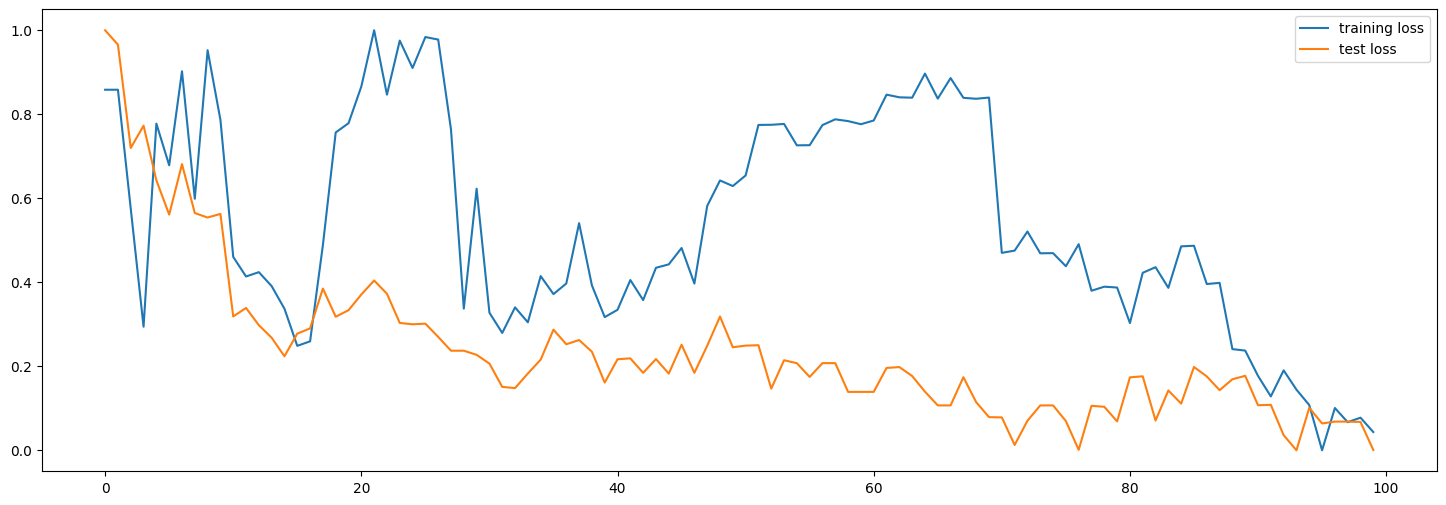

In [71]:
mse, hr_err, hr_err_sq = mod.eval()

print(f'\n\nMSE: {mse}')
print(f'HR error: {hr_err}')
print(f'HR error squared: {hr_err_sq}\n\n')

mod.get_model_stats()
mod.plot_loss()

True HR: 49.685767097966725; Pred HR: 71.50837988826815


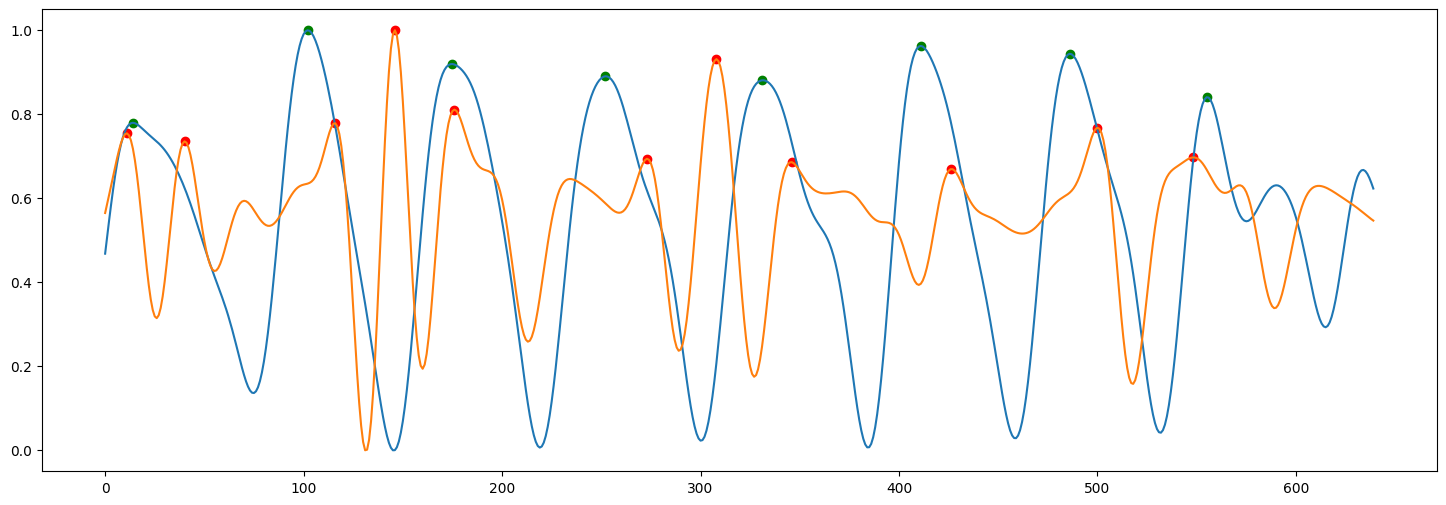

In [72]:
beg = 3000
end = beg + 640

model = mod

data = test_subject_truth.prepare_data_for_ml()
x = data.drop(columns = ['bvp']).to_numpy()
y = data['bvp'].to_numpy()

targ = y[beg: end]
pred = model.predict(x)[beg: end]
targ, pred = mod.process_signal(targ, pred, use_bandpass=True)

pred_peaks, _ = mod.get_predicted_peaks(pred)
true_peaks, _ = mod.get_true_peaks(targ)

plt.plot(targ)
plt.plot(pred)
plt.scatter(pred_peaks, pred[pred_peaks], c='r')
plt.scatter(true_peaks, targ[true_peaks], c='g')

pred_ibis = np.diff(pred_peaks) / 64
true_ibis = np.diff(true_peaks) / 64
pred_hr = get_hr(pred_ibis)
true_hr = get_hr(true_ibis)
print(f'True HR: {true_hr}; Pred HR: {pred_hr}')